# Real data

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
#from skimage import io 
from skimage.io import imread
# To manipulate arrays
import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
import rsnapsim as rss

from skimage.exposure import rescale_intensity
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image
import dna_features_viewer
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord, CircularGraphicRecord

# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
#video_dir = current_dir.parents[1].joinpath('DataBases','LargeDataSets','20190909_u2os_multiplex','smFLAG-KDM5B')
video_dir = current_dir.parents[1].joinpath('DataBases','LargeDataSets','20190909_u2os_multiplex','smFLAG-ActB')

rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')

# Importing rSNAPsim_IP
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp


In [2]:
#Function to detect all tif files in a folder
def folder_reader(folder):
    '''
    This function imports all tif files in a give folder.
    Input:
    folder: str, with the file name.

    Returns:
    list_files_names :  List of str with all file names
    path_files : List of str with all file paths
    '''
    # Reads the folder with the results and import the simulations as lists
    list_files_names = sorted([f for f in listdir(folder) if isfile(join(folder, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
    list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
    path_files = [ str(folder.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
    # Reading the microscopy data
    max_frames_to_read = 100
    list_videos = [imread(f)[0:max_frames_to_read,:,:,:] for f in  path_files] # List with all the videos. 
    num_videos = len(path_files) # the number of videos in the folder is the length of list_videos
    return path_files, list_files_names,list_videos, num_videos

In [3]:
# Load gene sequences
path_files,list_files_names,list_videos, num_videos = folder_reader(video_dir)
print(path_files)

['/home/luisub/Desktop/rsnaped/DataBases/LargeDataSets/20190909_u2os_multiplex/smFLAG-ActB/MAX_Cell01.tif', '/home/luisub/Desktop/rsnaped/DataBases/LargeDataSets/20190909_u2os_multiplex/smFLAG-ActB/MAX_Cell02.tif']


In [4]:
# Coding sequence
gene_file = str(sequences_dir.joinpath('Bactin_withTags.txt')) # coding sequence for SM_KDM5B_PP7    ### 5685 nt   ### 1895 codons
#gene_file= str(sequences_dir.joinpath('KDM5B_withTags.txt'))  # coding sequence for SM_p300_MS2      ### 8268 nt   ### 2756 codons

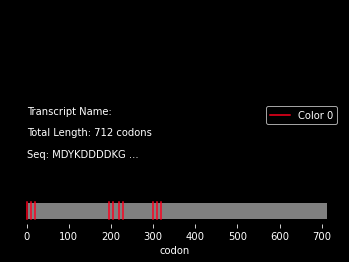

In [5]:
# Simulating a TASEP model for the beta-actin gene
poi_strs, poi_objs, tagged_pois,raw_seq = rss.seqmanip.open_seq_file(gene_file)  #open this file and find all valid protein of interest objs
gene_mrna = tagged_pois['1'][0]  #lets take the first one since thats the longest
rss.solver.protein = gene_mrna #pass this protein object to the solver
gene_mrna.visualize_probe()  # what does our construct look like?

In [6]:
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'max_area' # options are : 'max_spots' and 'max_area' 
use_optimization_for_tracking = 0 # 0 not using, 1 is using optimization
#frame_selection_empty_video = 'constant' # Options are: 'constant' , 'shuffle' and 'loop'
#particle_size = 3 # spot size for the simulation and tracking.
particle_detection_size = 5 # spot size for the simulation and tracking.

In [7]:
def plot_original_images(image,slice=0):
    '''
    This function plots all the channels for the original image.
    '''
    number_channels = image.shape[3]
    fig, axes = plt.subplots(nrows=1, ncols=number_channels, figsize=(15, 5))
    for i in range (0,number_channels ):
        img_2d = image[slice,:,:,i]
        img_2d_rescaled = rsp.RemoveExtrema(img_2d, min_percentile = 0.5, max_percentile= 99.5, selected_channels=[0,1]).remove_outliers()
        axes[i].imshow(img_2d_rescaled, cmap='viridis') 
        axes[i].set_title('Channel_'+str(i))
    plt.show()

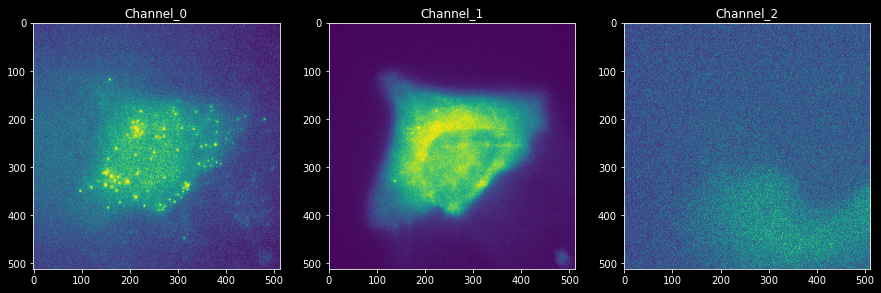

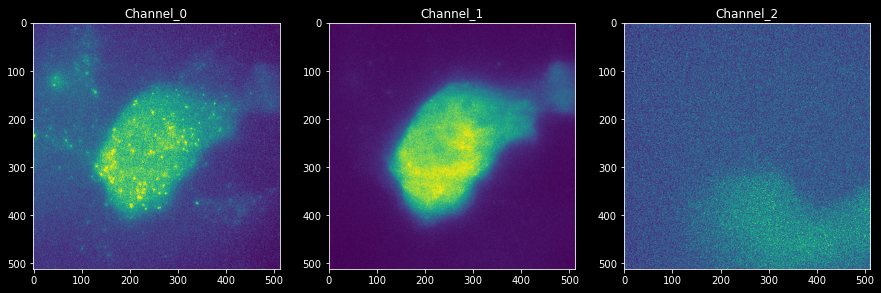

In [8]:
plot_original_images(list_videos[0])
plot_original_images(list_videos[1])

mask time: 6  sec
tracking time: 5  sec
intensity calculation time: 28  sec


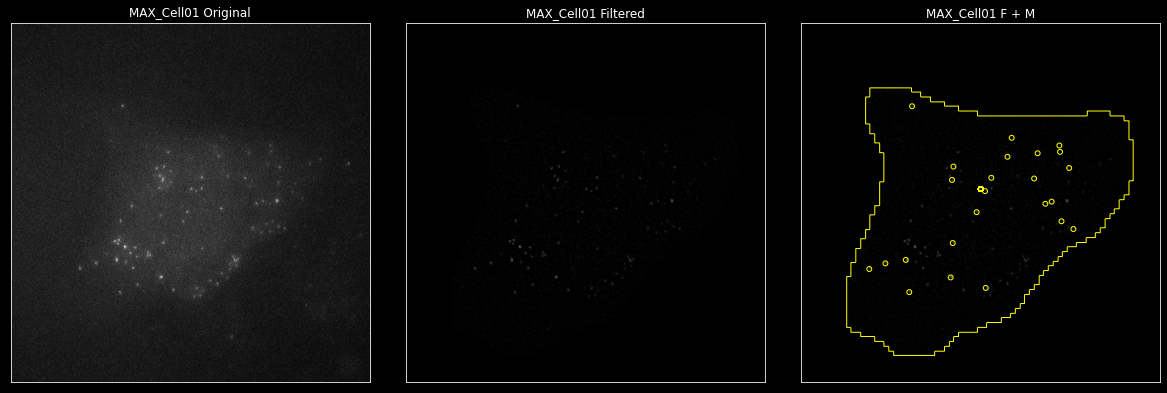

mask time: 4  sec
tracking time: 3  sec
intensity calculation time: 8  sec


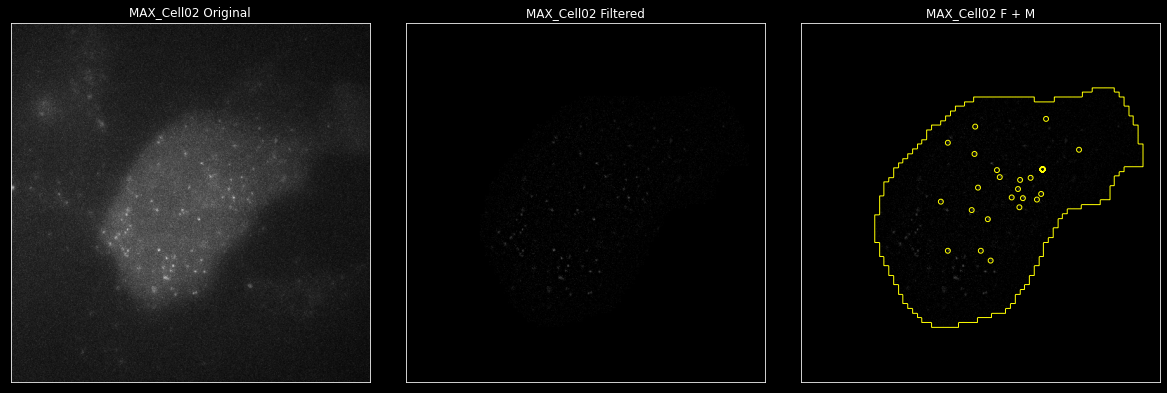

In [9]:
list_DataFrame_particles_intensities= []
for i, temp_video in enumerate(list_videos):
    DataFrame_particles_intensities, _, _, _,_, _, _ = rsp.PipelineTracking(temp_video,particle_size=particle_detection_size,file_name=list_files_names[i],selected_channel=0,intensity_calculation_method =intensity_calculation_method, mask_selection_method = mask_selection_method,show_plot=1,use_optimization_for_tracking=use_optimization_for_tracking,real_positions_dataframe = None, average_cell_diameter=200, print_process_times=1).run()    
    list_DataFrame_particles_intensities.append(DataFrame_particles_intensities)

In [42]:
all_data = True
sel_timepoint = 0
sel_cell = 0

In [43]:
df =list_DataFrame_particles_intensities[sel_cell]
df

,cell_number,particle,frame,red_int_mean,green_int_mean,blue_int_mean,red_int_std,green_int_std,blue_int_std,x,y,SNR_red,SNR_green,SNR_blue,background_int_mean_red,background_int_mean_green,background_int_mean_blue,background_int_std_red,background_int_std_green,background_int_std_blue
0,0,0,0,155.759995,14.660000,0.00,129.037756,101.326277,22.804000,158.044857,118.845868,20.921032,6.554041,22.631281,719.750000,1053.142822,558.214294,41.621273,157.026779,24.424601
1,0,0,1,161.820007,0.000000,0.92,162.309265,121.246763,24.877170,158.661910,118.398233,16.912310,6.700040,23.282555,717.464294,1051.767822,555.642883,51.697254,151.443878,23.748253
2,0,0,2,169.220001,27.020000,2.16,164.176617,146.585434,23.240792,158.642524,118.980106,16.284818,7.660185,22.348935,717.678589,1013.196411,551.607117,54.020866,134.529388,24.616833
3,0,0,3,200.339996,0.000000,0.00,163.960649,136.429404,18.659303,158.823301,118.856588,16.720674,6.827617,20.980737,721.892883,1044.017822,560.714294,54.713104,150.529831,26.094412
4,0,0,4,134.119995,0.000000,12.26,131.832718,96.813503,28.984520,158.253666,118.405470,15.757229,6.658100,25.062890,712.107117,1046.250000,556.232117,53.126091,149.015488,22.453915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3688,0,55,95,7.280000,5.060000,0.00,48.781570,214.320709,26.064658,351.813198,291.370051,9.169681,11.502722,22.374568,768.410706,3001.392822,558.142883,82.148987,261.204254,24.690533
3689,0,55,96,0.000000,16.400000,0.00,47.495684,279.001935,26.448259,352.422256,294.475610,12.011245,10.671970,18.079325,781.321411,3012.178467,565.232117,63.357296,281.709930,30.844072
3690,0,55,97,0.000000,3.920000,0.00,48.260029,248.574805,25.769874,353.970072,294.660475,12.731899,16.022515,22.702745,759.000000,3009.232178,568.857117,58.542721,190.976257,24.735334
3691,0,55,98,33.840000,90.279999,0.00,80.209566,265.297949,21.076091,351.419867,291.959037,8.010464,10.993544,17.737462,782.303589,3124.839355,569.446411,98.850700,289.104218,31.925650


In [44]:
print(list_videos[sel_cell][0,:,:,0].mean())
print(list_videos[sel_cell][0,:,:,1].mean())
print(list_videos[sel_cell][0,:,:,2].mean())

672.7538299560547
1172.349033355713
567.4455986022949


# Plotting figures

In [46]:
fig_size = (20, 5)
f = plt.figure(figsize=fig_size)
def fun_scatter_plot(x,y, title='', xlab='', ylab='',
                alpha=1, color='r',
                subplots=False, show_grid=True, fig=f):
    m, b = np.polyfit(x,y, 1)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    #axarr = f.add_subplot(1,1,1)
    plt.scatter(x, y, alpha=alpha, color=color)
    plt.plot(x, m*x + b,'-w',linewidth=2)
    plt.plot(mean_x,mean_y,'o',color='w' ,  markersize=20)
    plt.xlim(min(x), max(x))
    plt.xlabel(xlab, size=16)
    plt.ylabel(ylab, size=16)
    plt.grid(show_grid)
    plt.title(title, size=16)
    return(f)

<Figure size 1440x360 with 0 Axes>

## Channels

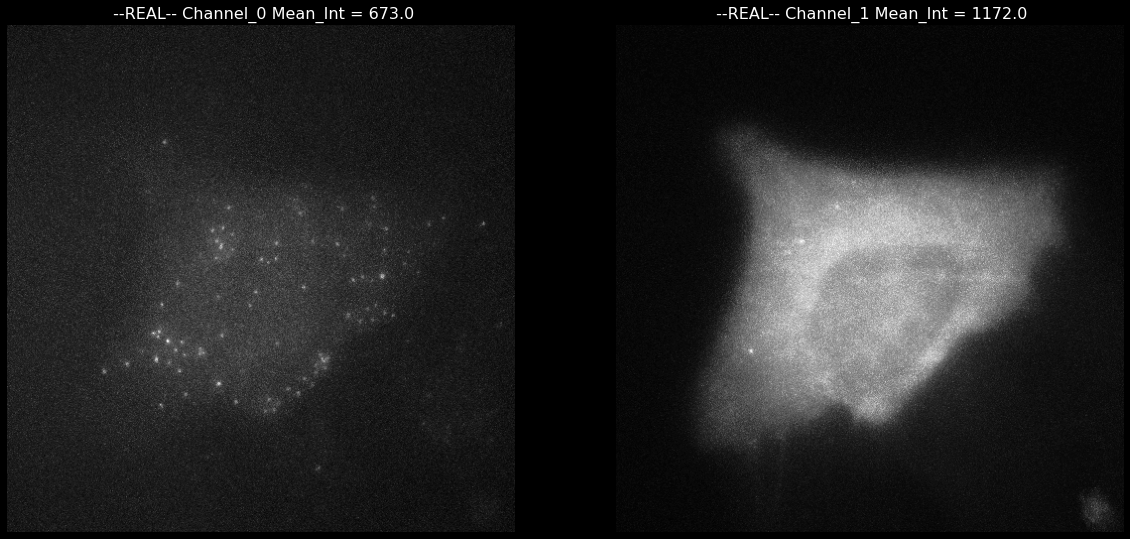

In [59]:
selected_timePoint = 0 # selecting a frame to display in the plot.
fig_size = (20, 10)
fig, ax = plt.subplots(ncols=2,nrows=1, figsize=fig_size)
for i in range(0,2):
  img = list_videos[sel_cell][selected_timePoint,:,:,i]
  mean_int = img.mean()
  #img= rsp.RemoveExtrema(img,min_percentile=1,max_percentile=99.9).remove_outliers()
  ax[i].imshow(img,cmap='Greys_r')
  ax[i].axis('off')
  ax[i].set_title(' --REAL-- Channel_'+str(i) + ' Mean_Int = ' +str(round(mean_int,0)) , size=16)
plt.savefig("./results/real_cell.png")
plt.show()


## Intensity distribution

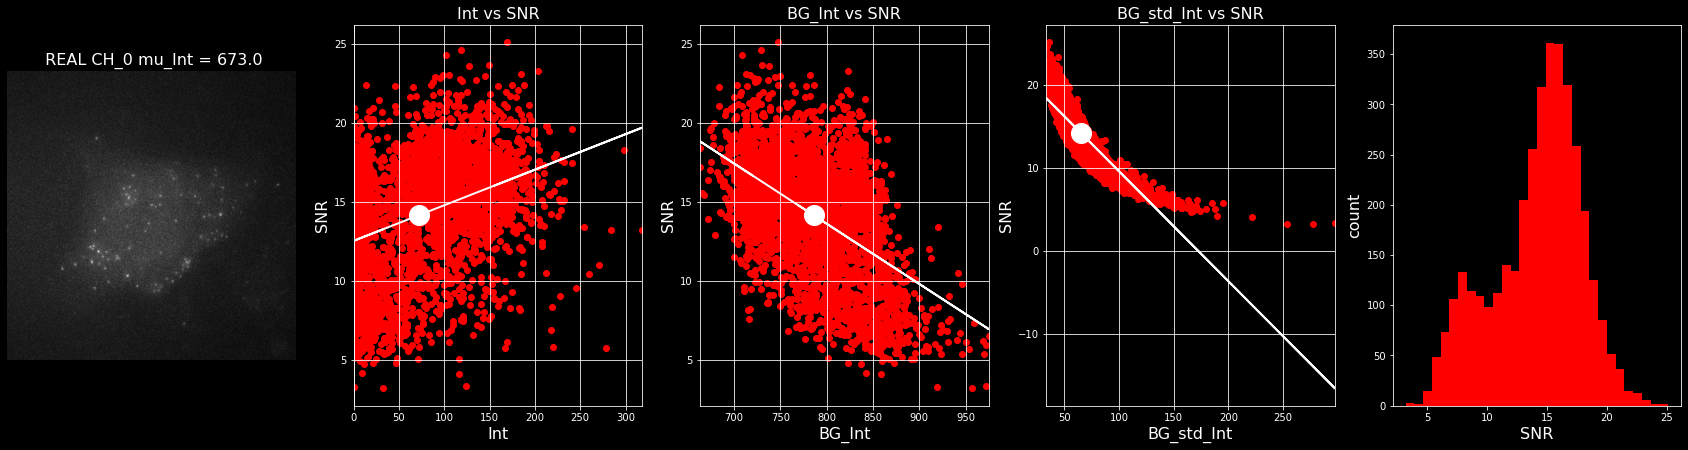

In [62]:
fig_size = (30, 7)
f = plt.figure(figsize=fig_size)

channel = 0
f.add_subplot(1,5,1) 
mean_int = list_videos[0][selected_timePoint,:,:,channel].mean()
plt.imshow(list_videos[0][selected_timePoint,:,:,channel],cmap='Greys_r')
plt.axis('off')
plt.title(' REAL CH_'+str(channel) + ' mu_Int = ' +str(round(mean_int,0)) , size=16)

f.add_subplot(1,5,2) 
fun_scatter_plot(x = df.red_int_mean.values, y= df.SNR_red.values, title='Int vs SNR', xlab='Int', ylab='SNR', fig=f, color='r')
f.add_subplot(1,5,3) 
fun_scatter_plot(x = df.background_int_mean_red.values, y= df.SNR_red.values, title='BG_Int vs SNR', xlab='BG_Int', ylab='SNR', fig=f, color='r')
f.add_subplot(1,5,4) 
fun_scatter_plot(x = df.background_int_std_red.values, y= df.SNR_red.values, title='BG_std_Int vs SNR', xlab='BG_std_Int', ylab='SNR', fig=f, color='r')

# adding the histogram
f.add_subplot(1,5,5) # here is where you add the subplot to f
f=plt.hist(df.SNR_red.values,bins=30,color='r')
#plt.title('dist SNR', size=16)
plt.ylabel('count', size=16)
plt.xlabel('SNR', size=16)
plt.savefig('./results/real_intensity_dist_ch0.png')
plt.show()

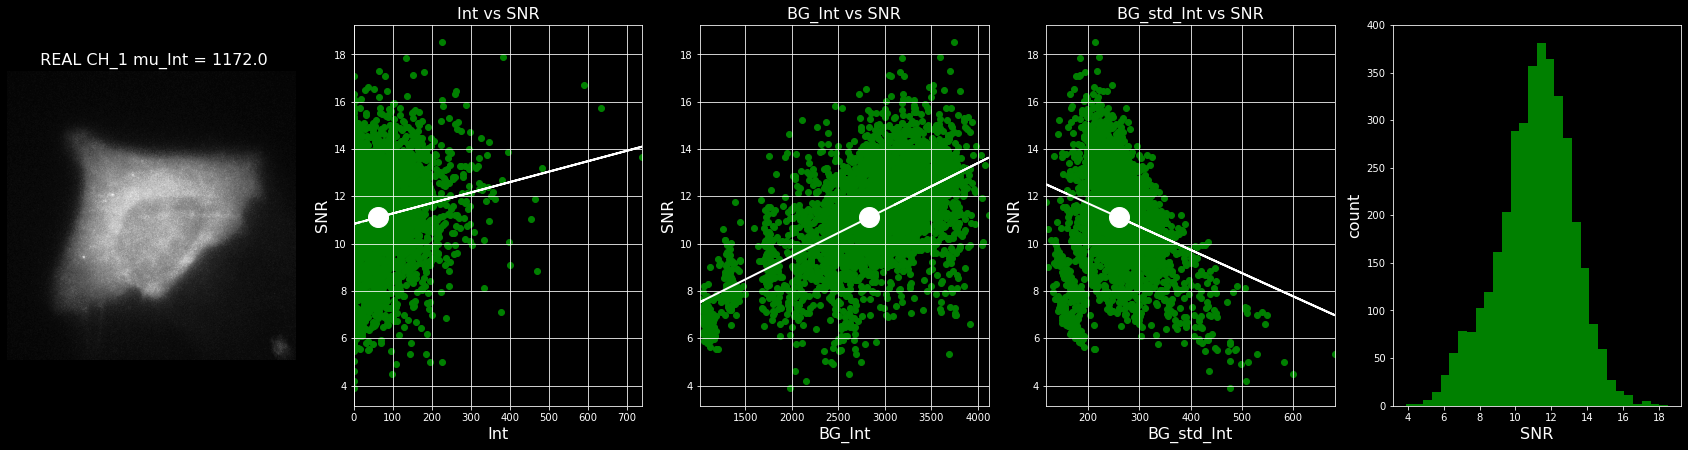

In [63]:
fig_size = (30, 7)
f = plt.figure(figsize=fig_size)

channel = 1
f.add_subplot(1,5,1) 
mean_int = list_videos[0][selected_timePoint,:,:,channel].mean()
plt.imshow(list_videos[0][selected_timePoint,:,:,channel],cmap='Greys_r')
plt.axis('off')
plt.title(' REAL CH_'+str(channel) + ' mu_Int = ' +str(round(mean_int,0)) , size=16)

f.add_subplot(1,5,2) 
fun_scatter_plot(x = df.green_int_mean.values, y= df.SNR_green.values, title='Int vs SNR', xlab='Int', ylab='SNR', fig=f, color='g')
f.add_subplot(1,5,3) 
fun_scatter_plot(x = df.background_int_mean_green.values, y= df.SNR_green.values, title='BG_Int vs SNR', xlab='BG_Int', ylab='SNR', fig=f, color='g')
f.add_subplot(1,5,4) 
fun_scatter_plot(x = df.background_int_std_green.values, y= df.SNR_green.values, title='BG_std_Int vs SNR', xlab='BG_std_Int', ylab='SNR', fig=f, color='g')

# adding the histogram
f.add_subplot(1,5,5) # here is where you add the subplot to f
f=plt.hist(df.SNR_green.values,bins=30,color='g')
#plt.title('dist SNR', size=16)
plt.ylabel('count', size=16)
plt.xlabel('SNR', size=16)

plt.savefig('./results/real_intensity_dist_ch1.png')
plt.show()
